# Experiment 4
## Comparing between different classifiers
Name: Xin Wei Lam<br>
Username: xl00751<br>
URN: 6525195

On researching implementations for multilabel text classification, I noticed that many tutorials used different classifiers. I wanted to compare the different classifiers and I used sklearn's page on "Choosing the right estimator" (https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html) as a guide to compare the most relevant classifiers.

Based on this, the classifiers I have chosen to compare are:
* Sequential Model (my group's base model)
* LinearSVC
* SGDClassifier
* Naive Bayes
    * Multinomial Naive Bayes
    * Complement Naive Bayes

The goal of this experiment is to determine the best classifier for our dataset and problem. I am aware that this experiment will not be the most accurate for determining the best classifier for the original dataset since SGDClassifier performs better for a larger number of samples, but it will be useful in eliminating classifiers that will not work.

I decided to compare every classifier with and without TFIDF as I wanted to observe the impact that TFIDF had on classification. I expect classifiers with TFIDF to perform better.

In [52]:
import keras
import numpy as np
import pandas as pd
import pickle
import sklearn
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.metrics import Accuracy

In [2]:
# File paths

# Data Directory
DATA_DIR = "data"

# Balanced datasets
BALANCED_TRAIN_DATASET = "data/balanced_dataset.pickle"
BALANCED_TEST_DATASET = "data/balanced_test_dataset.pickle"

# Preprocessed balanced data
PREPROCESSED_BAL_TRAIN_DATASET = "data/preprocessed_train.pickle"
PREPROCESSED_BAL_TEST_DATASET = "data/preprocessed_test.pickle"

In [55]:
# Function to load pickle file
# Params:
    # Str - @file_path: File path of pickle file
# Output:
    # Saved object in original file type (list/dataframe)
def load_pickle(file_path):
    return pickle.load(open(file_path, "rb"))

# Get accuracy with keras metrics Accuracy to do a quick comparison after each classifer has been trained
# Params:
#   Numpy array - @y_pred: Obtained prediction
# Output:
#   Tensor      - Accuracy result
def get_accuracy(y_pred):

    acc = Accuracy()
    acc.update_state(y_true, y_pred)
    return acc.result().numpy()

In [84]:
# Get preprocessed train dataset
bal_train_dataset = load_pickle(PREPROCESSED_BAL_TRAIN_DATASET)

# Get preprocessed test dataset
bal_test_dataset = load_pickle(PREPROCESSED_BAL_TEST_DATASET)

# Get train_y
bal_train_y = pd.read_pickle(BALANCED_TRAIN_DATASET)
bal_train_y = bal_train_y.drop(columns="comment_text")

# Get test_y
bal_test_y = pd.read_pickle(BALANCED_TEST_DATASET)
bal_test_y = bal_test_y.drop(columns="comment_text")

# Set y_true
y_true = bal_test_y

# Preparing the data without TFIDF

In [6]:
# Constants for preparing data
NUM_WORDS = 20000
MAX_LEN = 100

In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Use Tensorflow's Tokenizer for text featurization
tokenizer = Tokenizer(NUM_WORDS)

# Update internal vocabulary
tokenizer.fit_on_texts(bal_train_dataset)

# Turn each word into its corresponding integer
train_x = tokenizer.texts_to_sequences(bal_train_dataset)

# Pad sequences
train_x = keras.preprocessing.sequence.pad_sequences(train_x, MAX_LEN)
train_x = np.array(train_x)

In [8]:
# Prepare test_x

# Turn each word into its corresponding integer
test_x = tokenizer.texts_to_sequences(bal_test_dataset)

# Pad sequences
test_x = keras.preprocessing.sequence.pad_sequences(test_x, MAX_LEN)
test_x = np.array(test_x)

# Preparing the data with TFIDF
Using the best TFIDF variance from experiment 2

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Function to return itself, just to make sure TfidfVectorizer doesn't attempt to tokenize and preprocess my preprocessed tokens
def fake_function(comments):
    return comments

# Vectorize datasets according to the TfidfVectorizer object
# Params:
#   TfidfVectorizer - @tfidf: TfidfVectorizer object
#   List            - @train_data:  Preprocessed train dataset
#   List            - @test_data:   Preprocessed test dataset
# Output:
#   Numpy array - @train_x: Numpy array conversion of (SciPy sparse matrix) document term matrix of train dataset
#   Numpy array - @test_x:  Numpy array conversion of (SciPy sparse matrix) document term matrix of test dataset
def vectorize(tfidf, train_data, test_data):

    # Fit to vocabulary and transform
    train_x = tfidf.fit_transform(train_data).toarray()
    # Transform
    test_x = tfidf.transform(test_data).toarray()

    return train_x, test_x

In [ ]:
# Initialize TfidfVectorizer
tfidf = TfidfVectorizer(analyzer='word', tokenizer=fake_function, preprocessor=fake_function, token_pattern=None,min_df = 5, norm='l2', smooth_idf=True, sublinear_tf=True)

# Get vectors of train and test datasets
tfidf_train_x, tfidf_test_x = vectorize(tfidf, bal_train_dataset, bal_test_dataset)

# Sequential Model
## Without using TFIDF

In [42]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Dropout, Conv1D, GlobalMaxPooling1D, Embedding

# Basic model
def build_model(num_words):
    EPOCHS = 30
    INIT_LR = 1e-3

    model = Sequential()

    model.add(Embedding(num_words, 128))
    model.add(Dropout(0.4))
    model.add(Conv1D(128, 7, padding="valid", activation="relu", strides=3))
    model.add(Conv1D(128, 7, padding="valid", activation="relu", strides=3))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(6, activation='sigmoid'))

    adam = tf.keras.optimizers.Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

    model.compile(loss='binary_crossentropy',
                optimizer=adam,
                metrics=['accuracy'])

    return model

In [9]:
model = build_model(NUM_WORDS)

model.fit(train_x, bal_train_y, batch_size=60, epochs=30)

# Save model to use for evaluation
model.save('models/exp4_sequential')

Epoch 1/30
119/119 [==============================] - 23s 92ms/step - loss: 0.5691 - accuracy: 0.4294
Epoch 2/30
119/119 [==============================] - 12s 104ms/step - loss: 0.3765 - accuracy: 0.3866
Epoch 3/30
119/119 [==============================] - 12s 101ms/step - loss: 0.3003 - accuracy: 0.4087
Epoch 4/30
119/119 [==============================] - 13s 111ms/step - loss: 0.2782 - accuracy: 0.4418
Epoch 5/30
119/119 [==============================] - 12s 101ms/step - loss: 0.2568 - accuracy: 0.4450
Epoch 6/30
119/119 [==============================] - 12s 104ms/step - loss: 0.2464 - accuracy: 0.4506
Epoch 7/30
119/119 [==============================] - 12s 100ms/step - loss: 0.2377 - accuracy: 0.4739
Epoch 8/30
119/119 [==============================] - 10s 88ms/step - loss: 0.2210 - accuracy: 0.4807
Epoch 9/30
119/119 [==============================] - 10s 86ms/step - loss: 0.2052 - accuracy: 0.4858
Epoch 10/30
119/119 [==============================] - 10s 85ms/step - loss:

# Sequential Model
## Using TFIDF

In [47]:
# Basic model for TFIDF input
# Params:
#   Int - @n_features: Number of features from TfidfVectorizer
# Output:
#   Model
def tfidf_build_model(n_features):
    EPOCHS = 30
    INIT_LR = 1e-3

    model = Sequential()

    model.add(keras.Input(shape=(n_features, 1)))
    model.add(Dropout(0.4))
    model.add(Conv1D(128, 7, padding="valid", activation="relu", strides=3))
    model.add(Conv1D(128, 7, padding="valid", activation="relu", strides=3))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(6, activation='sigmoid'))

    adam = tf.keras.optimizers.Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

    model.compile(loss='binary_crossentropy',
                optimizer=adam,
                metrics=['accuracy'])

    return model

In [44]:
# Get number of features
tfidf_features = len(tfidf.get_feature_names())

# Pad for model & evaluation
tfidf_train_x_keras = np.expand_dims(tfidf_train_x, -1)
tfidf_test_x_keras = np.expand_dims(tfidf_test_x, -1)

print(tfidf_train_x_keras.shape)
print(tfidf_test_x_keras.shape)

(7132, 3819, 1)
(6978, 3819, 1)


In [48]:
model = tfidf_build_model(tfidf_features)

model.fit(tfidf_train_x_keras, bal_train_y, batch_size=60, epochs=30)

# Save model to use for evaluation
model.save('models/exp4_sequential_tfidf')

Epoch 1/30
119/119 [==============================] - 7s 44ms/step - loss: 0.6039 - accuracy: 0.2073
Epoch 2/30
119/119 [==============================] - 8s 66ms/step - loss: 0.5416 - accuracy: 0.3607
Epoch 3/30
119/119 [==============================] - 8s 67ms/step - loss: 0.5306 - accuracy: 0.3431
Epoch 4/30
119/119 [==============================] - 6s 48ms/step - loss: 0.5305 - accuracy: 0.3496
Epoch 5/30
119/119 [==============================] - 5s 46ms/step - loss: 0.5257 - accuracy: 0.4193
Epoch 6/30
119/119 [==============================] - 5s 45ms/step - loss: 0.5247 - accuracy: 0.3638
Epoch 7/30
119/119 [==============================] - 5s 45ms/step - loss: 0.5173 - accuracy: 0.4012
Epoch 8/30
119/119 [==============================] - 5s 45ms/step - loss: 0.5237 - accuracy: 0.4367
Epoch 9/30
119/119 [==============================] - 5s 45ms/step - loss: 0.5200 - accuracy: 0.3959
Epoch 10/30
119/119 [==============================] - 5s 45ms/step - loss: 0.5180 - accura

# Linear SVM
## Without TFIDF

In [50]:
from sklearn.svm import LinearSVC
from sklearn.multioutput import MultiOutputClassifier

In [85]:
# Initialize and fit the classifier
linear_svm = LinearSVC(penalty='l2', loss='squared_hinge', dual=False, max_iter=10000, multi_class='ovr', class_weight='balanced')

# Convert to a multilabel classifier
multilabel_svm = MultiOutputClassifier(linear_svm, n_jobs=-1)
multilabel_svm.fit(train_x, bal_train_y)

# Get predictions
y_pred = multilabel_svm.predict(test_x)
y_pred_svm = (y_pred > 0.5).astype("int32")

# Get accuracy
acc = get_accuracy(y_pred_svm)
print(acc)

0.37835577


# Linear SVM
## With TFIDF

In [86]:
# Initialize and fit the classifier
linear_svm_tfidf = LinearSVC(penalty='l2', loss='squared_hinge', dual=False, max_iter=10000, multi_class='ovr', class_weight='balanced')

# Convert to a multilabel classifier
multilabel_svm_tfidf = MultiOutputClassifier(linear_svm_tfidf, n_jobs=-1)
multilabel_svm_tfidf.fit(tfidf_train_x, bal_train_y)

# Get predictions
y_pred = multilabel_svm_tfidf.predict(tfidf_test_x)
y_pred_svm_tfidf = (y_pred > 0.5).astype("int32")

# Get accuracy
acc = get_accuracy(y_pred_svm_tfidf)
print(acc)

0.8654103


# SGDClassifier
## Without TFIDF
I used GridSearchCV to determine the best hyperparameters for the classifier. The accuracy result was very low even with the best hyperparameters.

In [10]:
from sklearn.linear_model import SGDClassifier

I realized afterwards that I had used the wrong hyperparameters, I did not need to include class_weight=None. However, the run took several hours and I did not have sufficient time to re-run it with the correct hyperparameters, so I built the classifier with the hyperparameters obtained from this GridSearch.

In [55]:
# Please don't run this cell, it ran overnight between 4-8 hours.

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

parameters = {
     'estimator__learning_rate': ['adaptive', 'constant'],
     'estimator__eta0': np.arange(0.01, 1.0, 0.01),
     'estimator__class_weight': ['balanced', None],
}

gs_clf = GridSearchCV(multilabel_sgd, parameters, n_jobs=-1, scoring='accuracy', refit=True)

gs_clf.fit(train_x, bal_train_y)

print(gs_clf.best_score_)

for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

grid_predictions = gs_clf.predict(test_x) 
   
# print classification report 
print(classification_report(bal_test_y, grid_predictions)) 

0.1131722313900129
estimator__class_weight: None
estimator__eta0: 0.8
estimator__learning_rate: 'constant'
              precision    recall  f1-score   support

           0       0.46      0.16      0.24      3090
           1       0.06      0.07      0.06       367
           2       0.26      0.33      0.29      2009
           3       0.01      0.00      0.01       211
           4       0.26      0.43      0.32      1953
           5       0.12      0.17      0.14       712

   micro avg       0.25      0.26      0.25      8342
   macro avg       0.19      0.20      0.18      8342
weighted avg       0.31      0.26      0.25      8342
 samples avg       0.19      0.11      0.13      8342

C:\Users\lamxw\anaconda3\envs\grp7_env\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, m

In [87]:
# Initialize and fit the classifier
# Best hyperparameters acording to GridSearchCV
sgd = SGDClassifier(loss='squared_hinge', penalty='l2', max_iter=10000, learning_rate='constant', eta0=0.8, early_stopping=True, validation_fraction=0.3, n_iter_no_change=100, class_weight=None, average=False, n_jobs=-1, random_state=10)

# Convert to a multilabel classifier
multilabel_sgd = MultiOutputClassifier(sgd, n_jobs=-1)
multilabel_sgd.fit(train_x, bal_train_y)

# Get predictions
y_pred = multilabel_sgd.predict(test_x)
y_pred_sgd = (y_pred > 0.5).astype("int32")

# Get accuracy
acc = get_accuracy(y_pred_sgd)
print(acc)

0.6992691


# SGDClassifier
## With TFIDF
According to the SGDClassifier documentation, it says "always scale the input". I will scale the data with TFIDF.

In [88]:
from sklearn.multioutput import MultiOutputClassifier

# Initialize and fit the classifier
# Best hyperparameters acording to GridSearchCV
sgd = SGDClassifier(loss='squared_hinge', penalty='l2', max_iter=10000, learning_rate='constant', eta0=0.8, early_stopping=True, validation_fraction=0.3, n_iter_no_change=100, class_weight='balanced', average=False, n_jobs=-1, random_state=10)

# Convert to a multilabel classifier
multilabel_sgd_tfidf = MultiOutputClassifier(sgd, n_jobs=-1)
multilabel_sgd_tfidf.fit(tfidf_train_x, bal_train_y)

# Get predictions
y_pred = multilabel_sgd_tfidf.predict(tfidf_test_x)
y_pred_sgd_tfidf = (y_pred > 0.5).astype("int32")

# Get accuracy
acc = get_accuracy(y_pred_sgd_tfidf)
print(acc)

0.79046047


Likewise, I attempted to run GridSearch but according to the output logs, it was estimated to take 8-13 hours so I did not attempt it.

In [14]:
# Please don't run this cell, it ran overnight between 4-8 hours.

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.multioutput import MultiOutputClassifier

parameters = {
     'estimator__learning_rate': ['adaptive', 'constant'],
     'estimator__eta0': np.arange(0.01, 1.0, 0.05),
     'estimator__class_weight': ['balanced'],
}

sgd1 = SGDClassifier(loss='squared_hinge', penalty='l2', max_iter=10000, early_stopping=True, validation_fraction=0.3, n_iter_no_change=100, average=False, random_state=10)

# Make it an Multilabel classifier
multilabel_sgd_tfidf1 = MultiOutputClassifier(sgd1)

gs_clf = GridSearchCV(multilabel_sgd_tfidf1, parameters, n_jobs=-1, scoring='accuracy', refit=True, verbose=2)

gs_clf.fit(tfidf_train_x, bal_train_y)

print(gs_clf.best_score_)

for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

grid_predictions = gs_clf.predict(tfidf_test_x) 
   
# print classification report 
print(classification_report(bal_test_y, grid_predictions)) 

Fitting 5 folds for each of 40 candidates, totalling 200 fits


# Naive Bayes
## Multinomial vs Complement
## OneVsRest vs MultiOutputClassifier

There are 2 main Naive Bayes algorithms to explore - Multinomial and Complement. According to the documentation, Multinomial is suited for text classification. Complement is an extension of Multinomial and is more suited for unbalanced datasets.

There are also 2 ways to convert Naive Bayes into a multilabel classifier, using OneVsRest and MultiOutputClassifier. I will also be comparing the result of both.

# NB Multinomial (OneVsRest)
## Without TFIDF

In [18]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier

In [89]:
# Initialize and fit the classifier
multinomial_nb = MultinomialNB()

# Convert to a multilabel classifer
ovr_mnb = OneVsRestClassifier(multinomial_nb, n_jobs=-1)
ovr_mnb.fit(train_x, bal_train_y)

# Get predictions
y_pred = ovr_mnb.predict(test_x)
y_pred_ovr_mnb = (y_pred > 0.5).astype("int32")

# Get accuracy
acc = get_accuracy(y_pred_ovr_mnb)
print(acc)

0.34756854


## With TFIDF

In [90]:
# Initialize and fit the classifier
multinomial_nb = MultinomialNB()

# Convert to a multilabel classifier
ovr_mnb_tfidf = OneVsRestClassifier(multinomial_nb, n_jobs=-1)
ovr_mnb_tfidf.fit(tfidf_train_x, bal_train_y)

# Get predictions
y_pred = ovr_mnb_tfidf.predict(tfidf_test_x)
y_pred_ovr_mnb_tfidf = (y_pred > 0.5).astype("int32")

# Get accuracy
acc = get_accuracy(y_pred_ovr_mnb_tfidf)
print(acc)

0.8749642


# NB Multinomial (MultiOutputClassifier)
## Without TFIDF

In [20]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.multioutput import MultiOutputClassifier

In [91]:
# Initialize and fit the classifier
multinomial_nb = MultinomialNB()

# Convert to a multilabel classifier
multi_mnb = MultiOutputClassifier(multinomial_nb, n_jobs=-1)
multi_mnb.fit(train_x, bal_train_y)

# Get predictions
y_pred = multi_mnb.predict(test_x)
y_pred_multi_nmb = (y_pred > 0.5).astype("int32")

# Get accuracy
acc = get_accuracy(y_pred_multi_nmb)
print(acc)

0.34756854


## With TFIDF

In [92]:
# Initialize and fit the classifier
multinomial_nb = MultinomialNB()

# Convert to a multilabel classifier
multi_mnb_tfidf = MultiOutputClassifier(multinomial_nb, n_jobs=-1)
multi_mnb_tfidf.fit(tfidf_train_x, bal_train_y)

# Get predictions
y_pred = multi_mnb_tfidf.predict(tfidf_test_x)
y_pred_multi_nmb_tfidf = (y_pred > 0.5).astype("int32")

# Get accuracy
acc = get_accuracy(y_pred_multi_nmb_tfidf)
print(acc)

0.8749642


# NB Complement (OneVsRest)
## Without TFIDF
For Complement Naive Bayes, there is an extra parameter in the classifier for normalization. I will be comparing them with normalization=True and False.

In [23]:
from sklearn.naive_bayes import ComplementNB
from sklearn.multiclass import OneVsRestClassifier

### Normalization = False

In [93]:
# Initialize and fit the classifier
complement_nb = ComplementNB(norm=False)

# Convert to a multilabel classifier
ovr_cnb_false = OneVsRestClassifier(complement_nb, n_jobs=-1)
ovr_cnb_false.fit(train_x, bal_train_y)

# Get predictions
y_pred = ovr_cnb_false.predict(test_x)
y_pred_ovr_cnb_false = (y_pred > 0.5).astype("int32")

# Get accuracy
acc = get_accuracy(y_pred_ovr_cnb_false)
print(acc)

0.34642208


### Normalization = True

In [94]:
# Initialize and fit the classifier
complement_nb = ComplementNB(norm=True)

# Convert to a multilabel classifier
ovr_cnb_true = OneVsRestClassifier(complement_nb, n_jobs=-1)
ovr_cnb_true.fit(train_x, bal_train_y)

# Get predictions
y_pred = ovr_cnb_true.predict(test_x)
y_pred_ovr_cnb_true = (y_pred > 0.5).astype("int32")

# Get accuracy
acc = get_accuracy(y_pred_ovr_cnb_true)
print(acc)

0.23437949


## With TFIDF
### Normalization = False

In [95]:
# Initialize and fit the classifier
complement_nb = ComplementNB(norm=False)

# Convert to a multilabel classifier
ovr_cnb_tfidf_false = OneVsRestClassifier(complement_nb, n_jobs=-1)
ovr_cnb_tfidf_false.fit(tfidf_train_x, bal_train_y)

# Get predictions
y_pred = ovr_cnb_tfidf_false.predict(tfidf_test_x)
y_pred_ovr_cnb_tfidf_false = (y_pred > 0.5).astype("int32")

# Get accuracy
acc = get_accuracy(y_pred_ovr_cnb_tfidf_false)
print(acc)

0.7931117


### Normalization = True

In [96]:
# Initialize and fit the classifier
complement_nb = ComplementNB(norm=True)

# Convert to a multilabel classifier
ovr_cnb_tfidf_true = OneVsRestClassifier(complement_nb, n_jobs=-1)
ovr_cnb_tfidf_true.fit(tfidf_train_x, bal_train_y)

# Get predictions
y_pred = ovr_cnb_tfidf_true.predict(tfidf_test_x)
y_pred_ovr_cnb_tfidf_true = (y_pred > 0.5).astype("int32")

# Get accuracy
acc = get_accuracy(y_pred_ovr_cnb_tfidf_true)
print(acc)

0.8169963


# NB Complement (MultiOutputClassifier)
## Without TFIDF

In [26]:
from sklearn.naive_bayes import ComplementNB
from sklearn.multioutput import MultiOutputClassifier

### Normalization = False

In [97]:
# Initialize and fit the classifier
complement_nb = ComplementNB(norm=False)

# Convert to a multilabel classifier
multi_cnb_false = MultiOutputClassifier(complement_nb, n_jobs=-1)
multi_cnb_false.fit(train_x, bal_train_y)

# Get predictions
y_pred = multi_cnb_false.predict(test_x)
y_pred_multi_cnb_false = (y_pred > 0.5).astype("int32")

# Get accuracy
acc = get_accuracy(y_pred_multi_cnb_false)
print(acc)

0.34642208


### Normalization = True

In [98]:
# Initialize and fit the classifier
complement_nb = ComplementNB(norm=True)

# Convert to a multilabel classifier
multi_cnb_true = MultiOutputClassifier(complement_nb, n_jobs=-1)
multi_cnb_true.fit(train_x, bal_train_y)

# Get predictions
y_pred = multi_cnb_true.predict(test_x)
y_pred_multi_cnb_true = (y_pred > 0.5).astype("int32")

# Get accuracy
acc = get_accuracy(y_pred_multi_cnb_true)
print(acc)

0.23440336


## With TFIDF
### Normalization = False

In [99]:
# Initialize and fit the classifier
complement_nb = ComplementNB(norm=False)

# Convert to a multilabel classifier
multi_cnb_false_tfidf = MultiOutputClassifier(complement_nb, n_jobs=-1)
multi_cnb_false_tfidf.fit(tfidf_train_x, bal_train_y)

# Get predictions
y_pred = multi_cnb_false_tfidf.predict(tfidf_test_x)
y_pred_multi_cnb_false_tfidf = (y_pred > 0.5).astype("int32")

# Get accuracy
acc = get_accuracy(y_pred_multi_cnb_false_tfidf)
print(acc)

0.7931117


### Normalization = True

In [100]:
# Initialize and fit the classifier
complement_nb = ComplementNB(norm=True)

# Convert to a multilabel classifier
multi_cnb_true_tfidf = MultiOutputClassifier(complement_nb, n_jobs=-1)
multi_cnb_true_tfidf.fit(tfidf_train_x, bal_train_y)

# Get predictions
y_pred = multi_cnb_true_tfidf.predict(tfidf_test_x)
y_pred_multi_cnb_true_tfidf = (y_pred > 0.5).astype("int32")

# Get accuracy
acc = get_accuracy(y_pred_multi_cnb_true_tfidf)
print(acc)

0.8169963


# Evaluation

In [234]:
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_addons as tfa
from sklearn.metrics import classification_report, f1_score, multilabel_confusion_matrix, precision_score

In [130]:
# Number of labels for confusion matrix
NUM_CLASSES = 6

# Get confusion matrix
# Params:
#   Numpy Array -       @y_pred:    Obtained prediction
# Output:
#   Numpy Array(Int) -  @cm_result: Confusion matrix
def get_confusion_matrix(y_pred):

    confusion_matrix = tfa.metrics.MultiLabelConfusionMatrix(num_classes=NUM_CLASSES)
    confusion_matrix.update_state(y_true, y_pred)

    cm_result = confusion_matrix.result()
    # Replace NaNs with 0, cast matrix as int
    cm_result = np.where(np.isnan(cm_result), 0, cm_result).astype(int)

    return cm_result

# Construct confusion matrix
# Params:
#   Confusion matrix    - @confusion_matrix:    Confusion matrix of trained model
#   Int                 - @axes:                Size of plot (row, col)
#   List                - @class_label:         Dataset labels
def show_confusion_matrix(confusion_matrix, axes, class_label, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=["N", "P"], columns=["N", "P"],
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")

    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)

    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title(class_label)

# Plot confusion matrix
# Params:
#   Numpy array(Int)    - @confusion_matrix: Confusion matrix
#   List                - @labels: List of labels
def plot_confusion_matrix(confusion_matrix, labels):

    fig, ax = plt.subplots(2, 3, figsize=(12, 7))
        
    for axes, cm, label in zip(ax.flatten(), confusion_matrix, labels):
        show_confusion_matrix(cm, axes, label)

    fig.tight_layout()
    plt.show()

In [219]:
# Get labels
labels = list(bal_train_y.columns)

# Confusion matrix list by classifier
cm_list_by_classifier = []

# Get micro-average Precision score of each classifier
micro_precision_score = {}

# Get micro-average f1-score of each classifier
micro_f1 = {}

# Accuracy for each classifier
acc_dict = {}

# Confusion Matrix & Classification Reports
I will use these evaluation methods as a starting point to analyze how good each classifier is at classifying each label.

# Sequential Model
## Without TFIDF

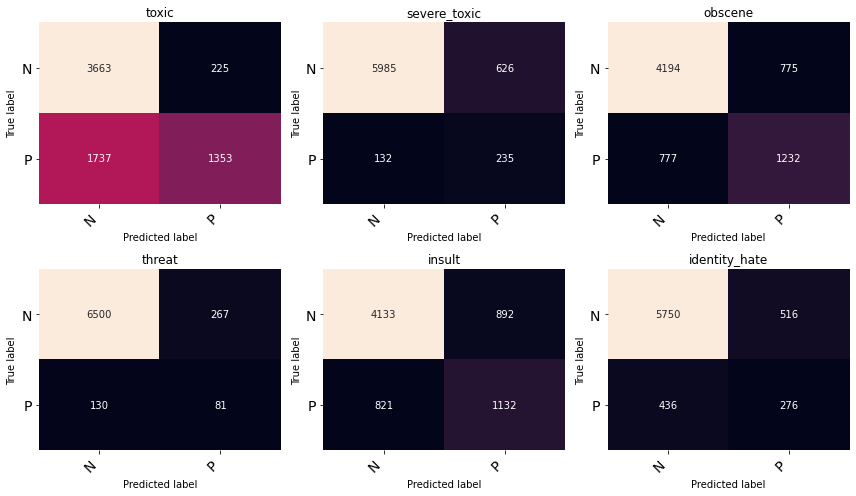

In [176]:
# Load model
sequential = keras.models.load_model('models/exp4_sequential')

# Predictions
y_pred = sequential.predict(test_x)
y_pred_sequential = (y_pred > 0.5).astype("int32")

# Get confusion matrix
seq_confusion_matrix = get_confusion_matrix(y_pred_sequential)

# Plot confusion matrix
plot_confusion_matrix(seq_confusion_matrix, labels)

This model is good $(\frac{FN}{TN} < 0.2)$ at classifying TN 'severe_toxic', 'threats' and 'identity_hate'. (3/6 labels)

It is decent $(\frac{FP}{TP} > 0.5)$ at classifying TP 'toxic'. (1/6 labels)

It is bad $(FP > TP$ or $\frac{FP}{TP} > 0.5)$ at classifying 'severe_toxic', 'obscene', 'threat', 'insult' and 'identity_hate'. (5/6 labels)

In [212]:
print(classification_report(y_true, y_pred_sequential, target_names=labels))

               precision    recall  f1-score   support

        toxic       0.86      0.44      0.58      3090
 severe_toxic       0.27      0.64      0.38       367
      obscene       0.61      0.61      0.61      2009
       threat       0.23      0.38      0.29       211
       insult       0.56      0.58      0.57      1953
identity_hate       0.35      0.39      0.37       712

    micro avg       0.57      0.52      0.54      8342
    macro avg       0.48      0.51      0.47      8342
 weighted avg       0.64      0.52      0.55      8342
  samples avg       0.19      0.21      0.18      8342

C:\Users\lamxw\anaconda3\envs\grp7_env\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lamxw\anaconda3\envs\grp7_env\lib\site-packages\sklear

This model does not perform well with both Precision and Recall as a whole, with low Precision for 'severe_toxic' and 'threat' and low Recall overall.

I will take micro-average f1-score and Precision score for comparing with other classifiers.

In [221]:
# Get accuracy
acc_dict['sequential'] = get_accuracy(y_pred_sequential)
# Get micro-F1
micro_f1['sequential'] = f1_score(y_true, y_pred_sequential, average='micro')
# Get micro-precision
micro_precision_score['sequential'] = precision_score(y_true, y_pred_sequential, average='micro')

# Get sum of confusion matrices by classifier
cm_sum = sum(seq_confusion_matrix)
cm_list_by_classifier.append(cm_sum.flatten())

# Sequential  Model
## With TFIDF

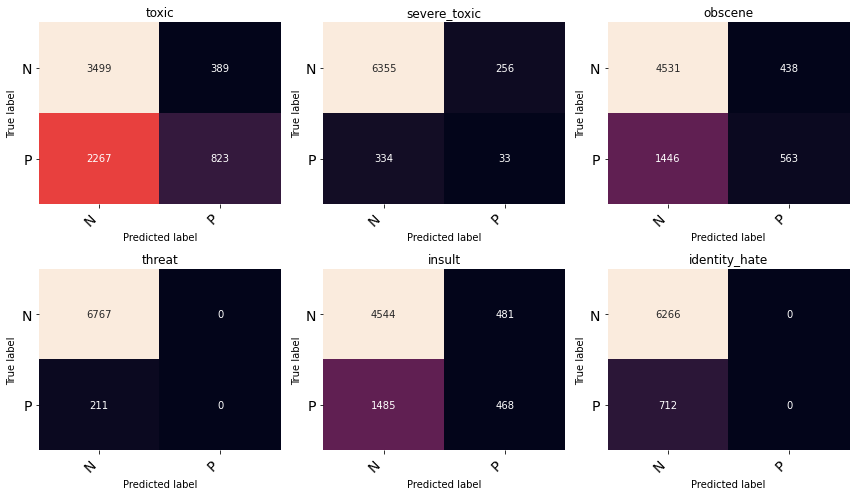

In [107]:
# Load model
sequential_tfidf = keras.models.load_model('models/exp4_sequential_tfidf')

# Predictions
y_pred = sequential_tfidf.predict(tfidf_test_x)
y_pred_sequential_tfidf = (y_pred > 0.5).astype("int32")

# Get confusion matrix
seq_tfidf_confusion_matrix = get_confusion_matrix(y_pred_sequential_tfidf)

# Plot confusion matrix
plot_confusion_matrix(seq_tfidf_confusion_matrix, labels)

This model failed at classifying 'threat' and 'identity_hate', so I will not take this classifier into consideration for future evaluations.

# Linear SVM
## Without TFIDF

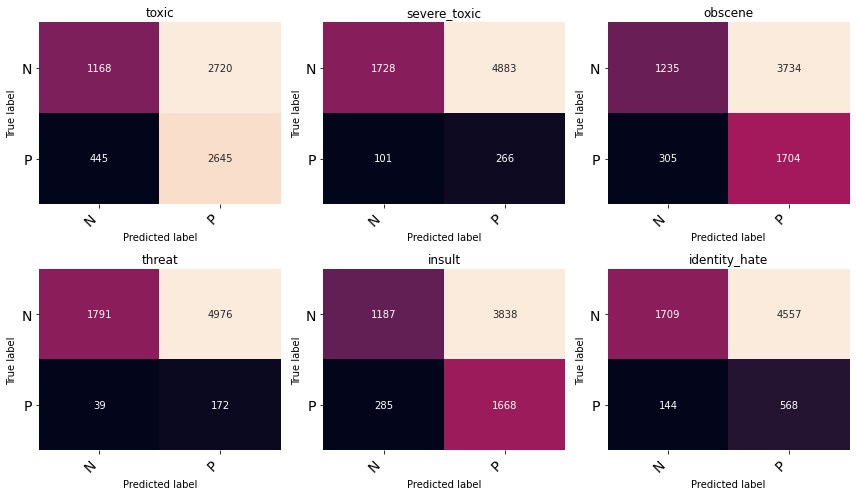

In [113]:
# Get confusion matrix
svm_confusion_matrix = get_confusion_matrix(y_pred_svm)

# Plot confusion matrix
plot_confusion_matrix(svm_confusion_matrix, labels)

This model is good $(\frac{FN}{TN} < 0.2)$ at classifying TN 'severe_toxic', 'threats' and 'identity_hate'. (3/6 labels)

It is decent $(\frac{FN}{TN} < 0.5)$ at classifying TN 'toxic', 'obscene' and 'insult. (3/6 labels)

It is bad $(FP > TP)$ at classifying 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult' and 'identity_hate'. (6/6 labels)

Since it is bad at classifying at all labels, I will not take this classifer into account for future evaluations.

# Linear SVM
## With TFIDF

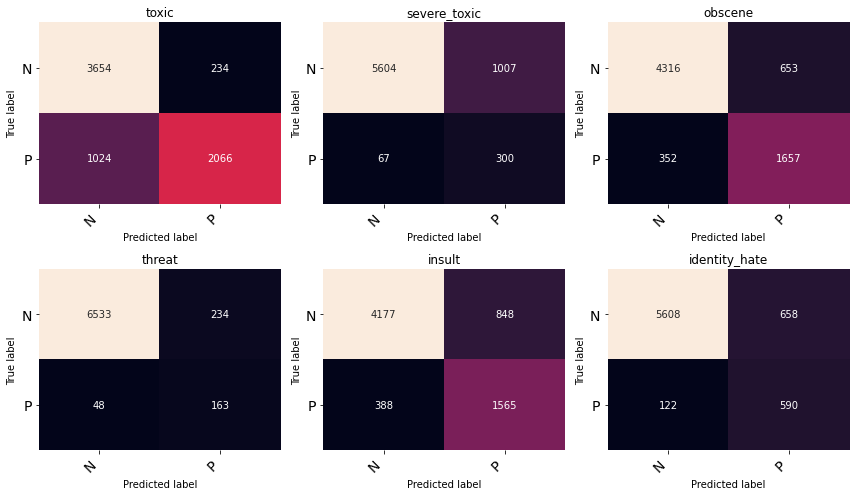

In [182]:
# Get confusion matrix
svm_tfidf_confusion_matrix = get_confusion_matrix(y_pred_svm_tfidf)

# Plot confusion matrix
plot_confusion_matrix(svm_tfidf_confusion_matrix, labels)

This model is good $(\frac{FN}{TN} < 0.2)$ at classifying TN 'severe_toxic', 'obscene', 'threat', 'insult' and 'identity_hate'. (5/6 labels)

It is decent $(\frac{FN}{TN} < 0.5)$ at classifying TN 'toxic'. (1/6 labels)

It is bad $(FP > TP$ or $\frac{FP}{TP} > 0.5)$ at classifying 'severe_toxic', 'threat', 'insult' and 'identity_hate'. (4/6 labels)

It is good $(\frac{FP}{TP} < 0.2)$ at classifying 'toxic'. (1/6 labels)

It is decent $(\frac{FP}{TP} < 0.5)$ at classifying 'obscene'. (1/6 labels)

In [181]:
print(classification_report(y_true, y_pred_svm_tfidf, target_names=labels))

               precision    recall  f1-score   support

        toxic       0.90      0.67      0.77      3090
 severe_toxic       0.23      0.82      0.36       367
      obscene       0.72      0.82      0.77      2009
       threat       0.41      0.77      0.54       211
       insult       0.65      0.80      0.72      1953
identity_hate       0.47      0.83      0.60       712

    micro avg       0.64      0.76      0.69      8342
    macro avg       0.56      0.79      0.62      8342
 weighted avg       0.72      0.76      0.72      8342
  samples avg       0.28      0.32      0.28      8342

C:\Users\lamxw\anaconda3\envs\grp7_env\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lamxw\anaconda3\envs\grp7_env\lib\site-packages\sklear

This model performs decent in Recall and worse in Precision, with the high Precision score for 'toxic' raising the micro-average for Precision.

The model is good at classifying 'toxic' and 'obscene' but worse at classifying 'threat'. I will take micro-average f1-score and precision scores for comparing with other classifiers.

In [222]:
# Get sum of confusion matrices by classifier
cm_sum = sum(svm_tfidf_confusion_matrix)
cm_list_by_classifier.append(cm_sum.flatten())

# Save F1-score
micro_f1['svm_tfidf'] = f1_score(y_true, y_pred_svm_tfidf, average='micro')
# Get accuracy
acc_dict['svm_tfidf'] = get_accuracy(y_pred_svm_tfidf)
# Get micro-precision
micro_precision_score['svm_tfidf'] = precision_score(y_true, y_pred_svm_tfidf, average='micro')

# SGDClassifier
## Without TFIDF

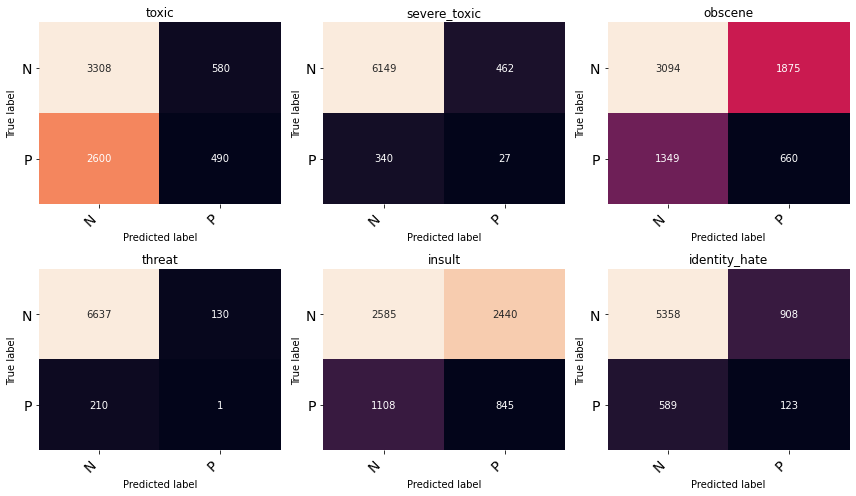

In [115]:
# Get confusion matrix
sgd_confusion_matrix = get_confusion_matrix(y_pred_sgd)

# Plot confusion matrix
plot_confusion_matrix(sgd_confusion_matrix, labels)

This model is good $(\frac{FN}{TN} < 0.2)$ at classifying TN 'severe_toxic', 'threat' and 'identity_hate'. (3/6 labels)

It is decent $(\frac{FN}{TN} < 0.5)$ at classifying TN 'obscene' and 'insult'. (2/6 labels)

It is bad $(FP > TP)$ at classifying 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult' and 'identity_hate'. (6/6 labels)

Since it is bad at classifying for all labels, I will not take this classifier into consideration for future evaluations.

# SGDClassifier
## With TFIDF

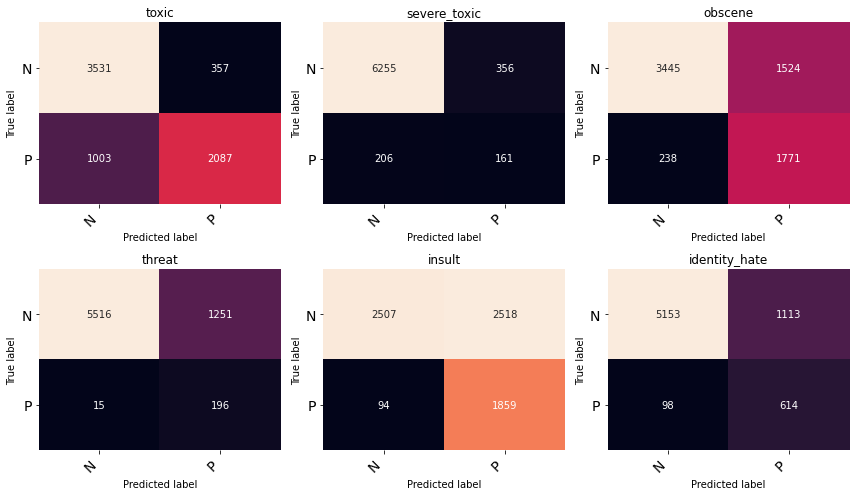

In [186]:
# Get confusion matrix
sgd_tfidf_confusion_matrix = get_confusion_matrix(y_pred_sgd_tfidf)

# Plot confusion matrix
plot_confusion_matrix(sgd_tfidf_confusion_matrix, labels)

This model is good $(\frac{FN}{TN} < 0.2)$ at classifying TN 'severe_toxic', 'obscene', 'threat', 'insult' and 'identity_hate'. (5/6 labels)

It is decent $(\frac{FN}{TN} < 0.5)$ at classifying TN 'toxic'. (1/6 labels)

It is bad $(FP > TP$ or $\frac{FP}{TP} > 0.5)$ at classifying 'severe_toxic', 'obscene', 'threat', 'insult' and 'identity_hate'. (5/6 labels)

It is good $(\frac{FP}{TP} < 0.2)$ at classifying 'toxic'. (1/6 labels)

In [185]:
print(classification_report(y_true, y_pred_sgd_tfidf, target_names=labels))

               precision    recall  f1-score   support

        toxic       0.85      0.68      0.75      3090
 severe_toxic       0.31      0.44      0.36       367
      obscene       0.54      0.88      0.67      2009
       threat       0.14      0.93      0.24       211
       insult       0.42      0.95      0.59      1953
identity_hate       0.36      0.86      0.50       712

    micro avg       0.48      0.80      0.60      8342
    macro avg       0.44      0.79      0.52      8342
 weighted avg       0.59      0.80      0.64      8342
  samples avg       0.27      0.34      0.29      8342

C:\Users\lamxw\anaconda3\envs\grp7_env\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lamxw\anaconda3\envs\grp7_env\lib\site-packages\sklear

This model is good at Recall, with most of Recall scores > 0.8. However, it performs poorly in Precision for most labels. I am focusing on Precision, so this classifier is not good with Precision. For comparisons' sake with other classifiers, I will store the F1-score.

In [225]:
# Get sum of confusion matrices by classifier
cm_sum = sum(sgd_tfidf_confusion_matrix)
cm_list_by_classifier.append(cm_sum.flatten())

# Save F1-score
micro_f1['sgd_tfidf'] = f1_score(y_true, y_pred_sgd_tfidf, average='micro')
# Get accuracy
acc_dict['sgd_tfidf'] = get_accuracy(y_pred_sgd_tfidf)
# Get micro-precision
micro_precision_score['sgd_tfidf'] = precision_score(y_true, y_pred_sgd_tfidf, average='micro')

# NB Multinomial (OneVsRest)
## Without TFIDF

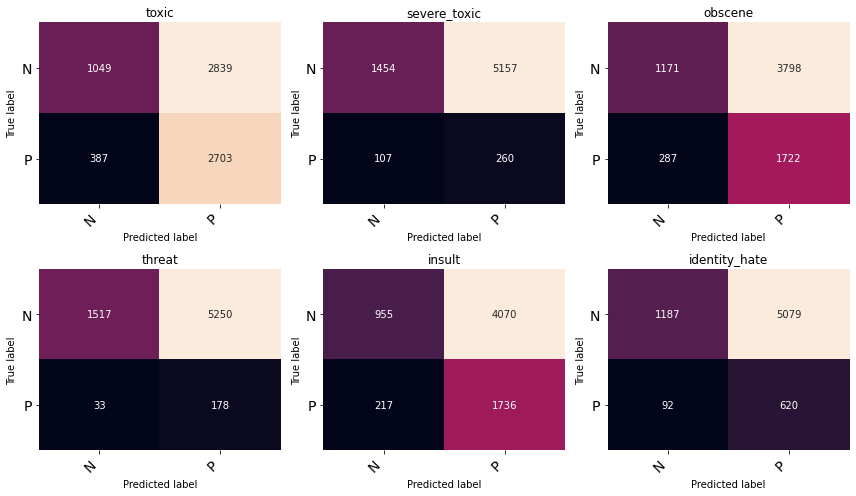

In [118]:
# Get confusion matrix
ovr_mnb_confusion_matrix = get_confusion_matrix(y_pred_ovr_mnb)

# Plot confusion matrix
plot_confusion_matrix(ovr_mnb_confusion_matrix, labels)

This model is good $(\frac{FN}{TN} < 0.2)$ at classifying TN 'severe_toxic', 'threat' and 'identity_hate'. (3/6 labels)

It is decent $(\frac{FN}{TN} < 0.5)$ at classifying TN 'toxic', 'obscene' and 'insult'. (3/6 labels)

It is bad $(FP > TP)$ at classifying 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult' and 'identity_hate'. (6/6 labels)

Since it is bad at classifying for all labels, I will not take this classifier into consideration for future evaluations.

# NB Multinomial (OneVsRest)
## With TFIDF

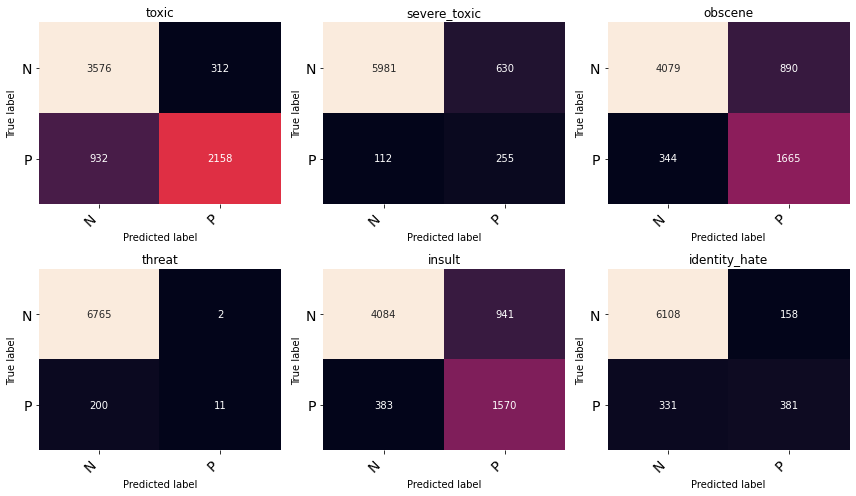

In [190]:
# Get confusion matrix
ovr_mnb_tfidf_confusion_matrix = get_confusion_matrix(y_pred_ovr_mnb_tfidf)

# Plot confusion matrix
plot_confusion_matrix(ovr_mnb_tfidf_confusion_matrix, labels)

This model is good $(\frac{FN}{TN} < 0.2)$ at classifying TN 'severe_toxic', 'obscene', 'threat', 'insult' and 'identity_hate'. (5/6 labels)

It is decent $(\frac{FN}{TN} < 0.5)$ at classifying TN 'toxic'. (1/6 labels)

It is bad $(FP > TP$ or $\frac{FP}{TP} > 0.5)$ at classifying 'severe_toxic', 'obscene', 'threat', 'insult' and 'identity_hate'. (5/6 labels)

It is good $(\frac{FP}{TP} < 0.2)$ at classifying 'toxic'. (1/6 labels)

In [189]:
print(classification_report(y_true, y_pred_ovr_mnb_tfidf, target_names=labels))

               precision    recall  f1-score   support

        toxic       0.87      0.70      0.78      3090
 severe_toxic       0.29      0.69      0.41       367
      obscene       0.65      0.83      0.73      2009
       threat       0.85      0.05      0.10       211
       insult       0.63      0.80      0.70      1953
identity_hate       0.71      0.54      0.61       712

    micro avg       0.67      0.72      0.70      8342
    macro avg       0.67      0.60      0.55      8342
 weighted avg       0.72      0.72      0.70      8342
  samples avg       0.27      0.31      0.27      8342

C:\Users\lamxw\anaconda3\envs\grp7_env\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lamxw\anaconda3\envs\grp7_env\lib\site-packages\sklear

This model has decent Precision and Recall for 'toxic', 'obscene' and 'insult', but has poor precision for 'severe_toxic'. Recall for 'threat' is extremely low at 0.05. It has poorer F1-scores for 'severe_toxic', 'threat' and 'identity_hate', making it not a good classifier.

The high Precision and Recall for a few labels raises the overall micro-averages, making the classifier seem better than it is.

For comparisons' sake with other classifiers, I will store the F1-score and Precision score.

In [228]:
# Get sum of confusion matrices by classifier
cm_sum = sum(ovr_mnb_tfidf_confusion_matrix)
cm_list_by_classifier.append(cm_sum.flatten())

# Save F1-score
micro_f1['ovr_mnb_tfidf'] = f1_score(y_true, y_pred_ovr_mnb_tfidf, average='micro')
# Get accuracy
acc_dict['ovr_mnb_tfidf'] = get_accuracy(y_pred_ovr_mnb_tfidf)
# Get micro-precision
micro_precision_score['ovr_mnb_tfidf'] = precision_score(y_true, y_pred_ovr_mnb_tfidf, average='micro')

# NB Multinomial (MultiOutputClassifier)
## Without TFIDF

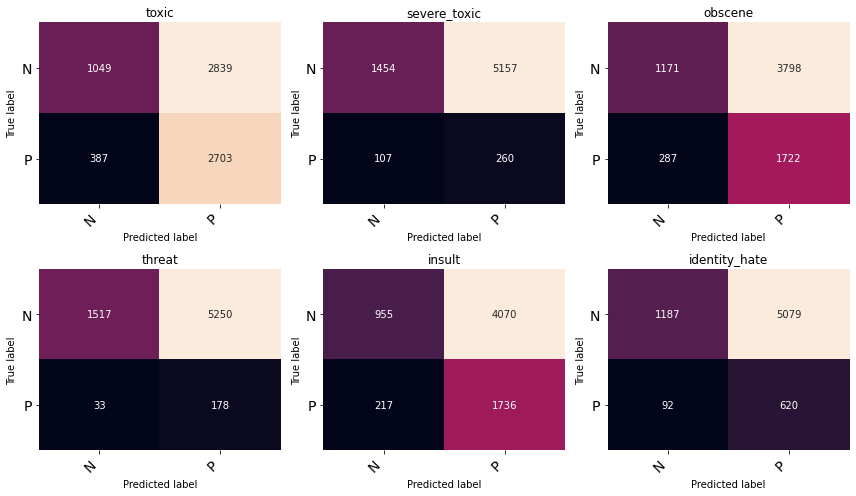

In [120]:
# Get confusion matrix
multi_mnb_confusion_matrix = get_confusion_matrix(y_pred_multi_nmb)

# Plot confusion matrix
plot_confusion_matrix(multi_mnb_confusion_matrix, labels)

This model is good $(\frac{FN}{TN} < 0.2)$ at classifying TN 'severe_toxic', 'threat' and 'identity_hate'. (3/6 labels)

It is decent $(\frac{FN}{TN} < 0.5)$ at classifying TN 'toxic', 'obscene' and 'insult'. (1/6 labels)

It is bad $(FP > TP)$ at classifying 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult' and 'identity_hate'. (6/6 labels)

Since it is bad at classifying for all labels, I will not take this classifier into consideration for future evaluations.

# NB Multinomial (MultiOutputClassifier)
## With TFIDF

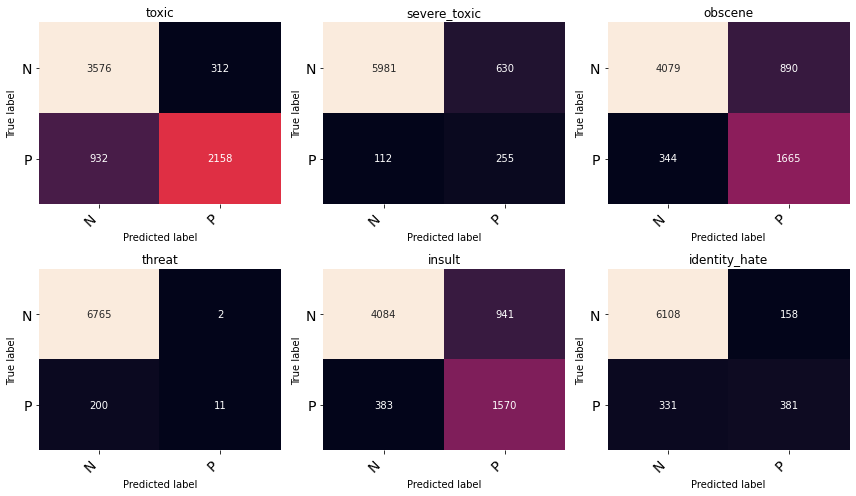

In [193]:
# Get confusion matrix
multi_mnb_tfidf_confusion_matrix = get_confusion_matrix(y_pred_multi_nmb_tfidf)

# Plot confusion matrix
plot_confusion_matrix(multi_mnb_tfidf_confusion_matrix, labels)

This model is good $(\frac{FN}{TN} < 0.2)$ at classifying TN 'severe_toxic', 'obscene', 'threat', 'insult' and 'identity_hate'. (5/6 labels)

It is decent $(\frac{FN}{TN} < 0.5)$ at classifying TN 'toxic'. (1/6 labels)

It is bad $(FP > TP$ or $\frac{FP}{TP} > 0.5)$ at classifying 'severe_toxic', 'obscene' and 'insult'. (3/6 labels)

It is good $(\frac{FP}{TP} < 0.2)$ at classifying 'toxic' and 'threat'. (1/6 labels) However, it only classified a total of 13 threats.

In [194]:
print(classification_report(y_true, y_pred_multi_nmb_tfidf, target_names=labels))

               precision    recall  f1-score   support

        toxic       0.87      0.70      0.78      3090
 severe_toxic       0.29      0.69      0.41       367
      obscene       0.65      0.83      0.73      2009
       threat       0.85      0.05      0.10       211
       insult       0.63      0.80      0.70      1953
identity_hate       0.71      0.54      0.61       712

    micro avg       0.67      0.72      0.70      8342
    macro avg       0.67      0.60      0.55      8342
 weighted avg       0.72      0.72      0.70      8342
  samples avg       0.27      0.31      0.27      8342

C:\Users\lamxw\anaconda3\envs\grp7_env\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lamxw\anaconda3\envs\grp7_env\lib\site-packages\sklear

This model has decent Precision and Recall for 'toxic', 'obscene' and 'insult', but has poor precision for 'severe_toxic'. Recall for 'threat' is extremely low at 0.05. It has poorer F1-scores for 'severe_toxic', 'threat' and 'identity_hate', making it not a good classifier.

The high Precision and Recall for a few labels raises the overall micro-averages, making the classifier seem better than it is.

For comparisons' sake with other classifiers, I will store the F1-score and Precision score.

In [229]:
# Get sum of confusion matrices by classifier
cm_sum = sum(multi_mnb_tfidf_confusion_matrix)
cm_list_by_classifier.append(cm_sum.flatten())

# Save F1-score
micro_f1['multi_nmb_tfidf'] = f1_score(y_true, y_pred_multi_nmb_tfidf, average='micro')
# Get accuracy
acc_dict['multi_nmb_tfidf'] = get_accuracy(y_pred_multi_nmb_tfidf)
# Get micro-precision
micro_precision_score['multi_nmb_tfidf'] = precision_score(y_true, y_pred_multi_nmb_tfidf, average='micro')

# NB Complement (OneVsRest)
## Without TFIDF
### Normalization = False

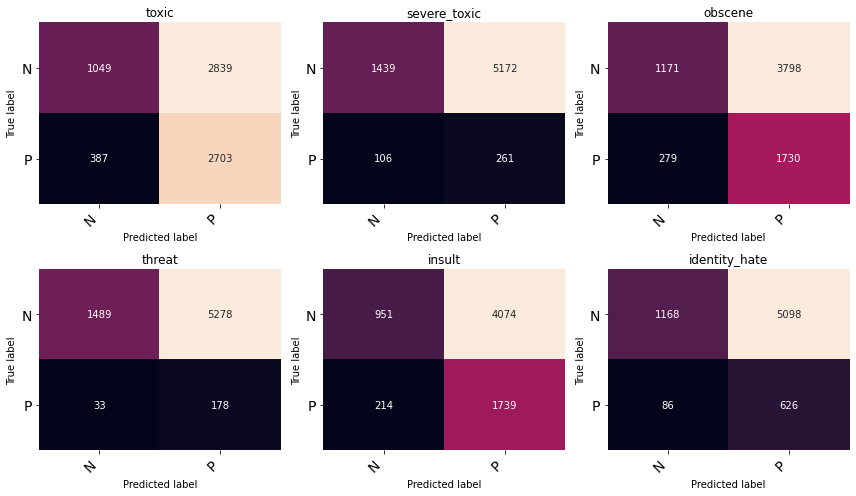

In [122]:
# Get confusion matrix
ovr_cnb_false_confusion_matrix = get_confusion_matrix(y_pred_ovr_cnb_false)

# Plot confusion matrix
plot_confusion_matrix(ovr_cnb_false_confusion_matrix, labels)

This model is good $(\frac{FN}{TN} < 0.2)$ at classifying TN 'severe_toxic', 'threat' and 'identity_hate'. (3/6 labels)

It is decent $(\frac{FN}{TN} < 0.5)$ at classifying TN 'toxic', 'obscene' and 'insult'. (3/6 labels)

It is bad $(FP > TP)$at classifying 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult' and 'identity_hate'. (6/6 labels)

Since it is bad at classifying for all labels, I will not take this classifier into consideration for future evaluations.

# NB Complement (OneVsRest)
## Without TFIDF
### Normalization = True

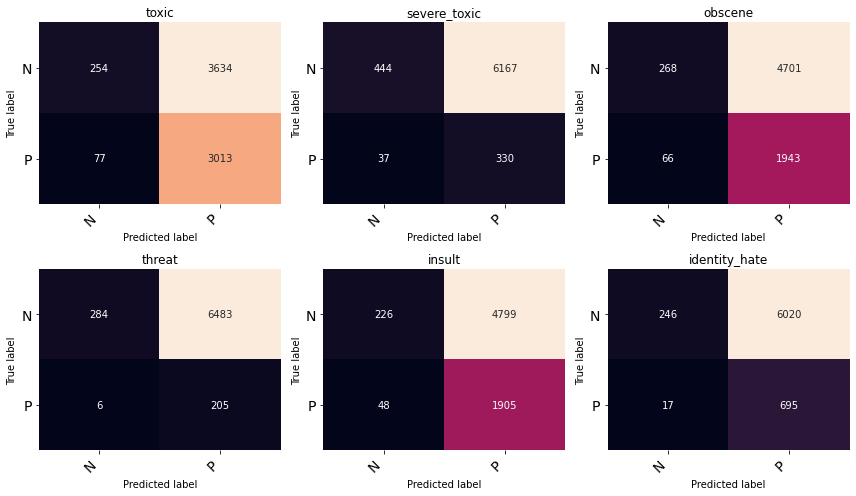

In [123]:
# Get confusion matrix
ovr_cnb_true_confusion_matrix = get_confusion_matrix(y_pred_ovr_cnb_true)

# Plot confusion matrix
plot_confusion_matrix(ovr_cnb_true_confusion_matrix, labels)

This model is good $(\frac{FN}{TN} < 0.2)$ at classifying TN 'severe_toxic', 'threat' and 'identity_hate'. (3/6 labels)

It is decent $(\frac{FN}{TN} < 0.5)$ at classifying TN 'toxic', 'obscene' and 'insult'. (3/6 labels)

However, it has detected a low number of negative samples.

It is bad $(FP > TP)$at classifying 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult' and 'identity_hate'. (6/6 labels)

Since it is bad at classifying for all labels, I will not take this classifier into consideration for future evaluations.

# NB Complement (OneVsRest)
## With TFIDF
### Normalization = False

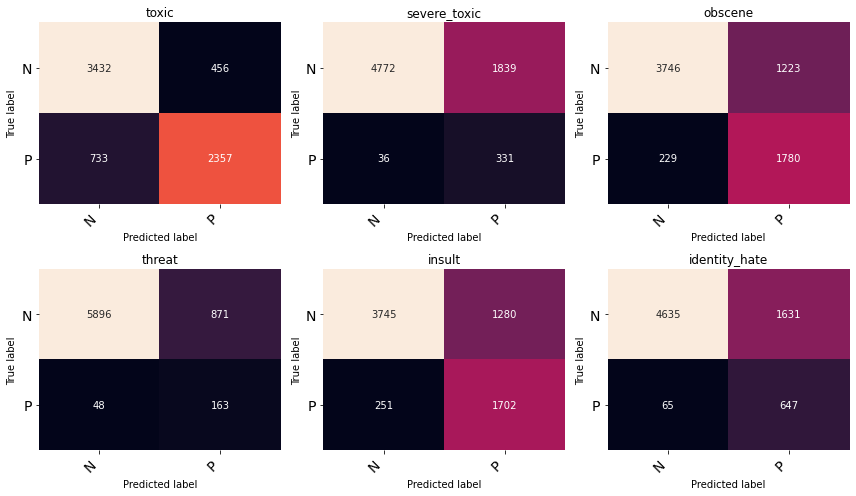

In [124]:
# Get confusion matrix
ovr_cnb_tfidf_false_confusion_matrix = get_confusion_matrix(y_pred_ovr_cnb_tfidf_false)

# Plot confusion matrix
plot_confusion_matrix(ovr_cnb_tfidf_false_confusion_matrix, labels)

This model is good $(\frac{FN}{TN} < 0.2)$ at classifying TN 'severe_toxic', 'obscene', 'threat', 'insult' and 'identity_hate'. (5/6 labels)

It is decent $(\frac{FN}{TN} < 0.5)$ at classifying TN 'toxic'. (1/6 labels)

It is bad $(FP > TP$ or $\frac{FP}{TP} > 0.5)$ at classifying 'severe_toxic', 'obscene', 'threat', 'insult' and 'identity_hate'. (5/6 labels)

It is good $(\frac{FP}{TP} < 0.2)$ at classifying 'toxic'. (1/6 labels)

In [198]:
print(classification_report(y_true, y_pred_ovr_cnb_tfidf_false, target_names=labels))

               precision    recall  f1-score   support

        toxic       0.84      0.76      0.80      3090
 severe_toxic       0.15      0.90      0.26       367
      obscene       0.59      0.89      0.71      2009
       threat       0.16      0.77      0.26       211
       insult       0.57      0.87      0.69      1953
identity_hate       0.28      0.91      0.43       712

    micro avg       0.49      0.84      0.62      8342
    macro avg       0.43      0.85      0.53      8342
 weighted avg       0.62      0.84      0.68      8342
  samples avg       0.23      0.36      0.27      8342

C:\Users\lamxw\anaconda3\envs\grp7_env\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lamxw\anaconda3\envs\grp7_env\lib\site-packages\sklear

This model performs well in Recall with every score > 0.7, however it performs poorly in Precision with < 0.2 for 'severe_toxic' and 'threat'. It has a low micro-average Precision score. I will further compare with the next classifier to assess the classifier to use for further evaluations.

# NB Complement (OneVsRest)
## With TFIDF
### Normalization = True

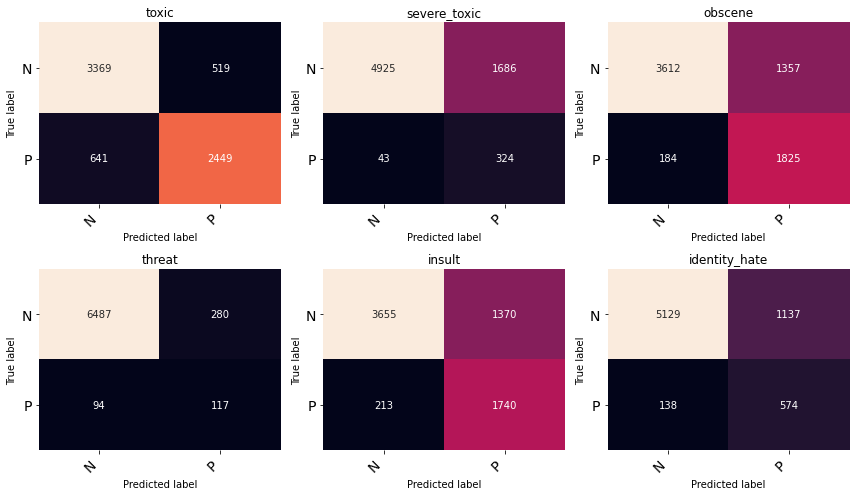

In [125]:
# Get confusion matrix
ovr_cnb_tfidf_true_confusion_matrix = get_confusion_matrix(y_pred_ovr_cnb_tfidf_true)

# Plot confusion matrix
plot_confusion_matrix(ovr_cnb_tfidf_true_confusion_matrix, labels)

This model is good $(\frac{FN}{TN} < 0.2)$ at classifying TN 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult' and 'identity_hate'. (6/6 labels)

It is bad $(FP > TP$ or $\frac{FP}{TP} > 0.5)$ at classifying 'severe_toxic', 'obscene', 'threat', 'insult' and 'identity_hate'. (5/6 labels)

It is good $(\frac{FP}{TP} < 0.2)$ at classifying 'toxic'. (1/6 labels)

In [199]:
print(classification_report(y_true, y_pred_ovr_cnb_tfidf_true, target_names=labels))

               precision    recall  f1-score   support

        toxic       0.83      0.79      0.81      3090
 severe_toxic       0.16      0.88      0.27       367
      obscene       0.57      0.91      0.70      2009
       threat       0.29      0.55      0.38       211
       insult       0.56      0.89      0.69      1953
identity_hate       0.34      0.81      0.47       712

    micro avg       0.53      0.84      0.65      8342
    macro avg       0.46      0.81      0.56      8342
 weighted avg       0.62      0.84      0.69      8342
  samples avg       0.25      0.37      0.28      8342

C:\Users\lamxw\anaconda3\envs\grp7_env\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lamxw\anaconda3\envs\grp7_env\lib\site-packages\sklear

This model performs well in Recall with every score > 0.7 with the exception of 'threat'. It performs poorly in Precision with < 0.2 for 'severe_toxic'. This classifer has a higher micro-average F1-score and Precision score than the previous, thus for comparisons' sake I will use this classifier for future evaluations.

In [230]:
# Get sum of confusion matrices by classifier
cm_sum = sum(ovr_cnb_tfidf_true_confusion_matrix)
cm_list_by_classifier.append(cm_sum.flatten())

# Save F1-score
micro_f1['ovr_cnb_tfidf_true'] = f1_score(y_true, y_pred_ovr_cnb_tfidf_true, average='micro')
# Get accuracy
acc_dict['ovr_cnb_tfidf_true'] = get_accuracy(y_pred_ovr_cnb_tfidf_true)
# Get micro-precision
micro_precision_score['ovr_cnb_tfidf_true'] = precision_score(y_true, y_pred_ovr_cnb_tfidf_true, average='micro')

# NB Complement (MultiOutputClassifier)
## Without TFIDF
### Normalization = False

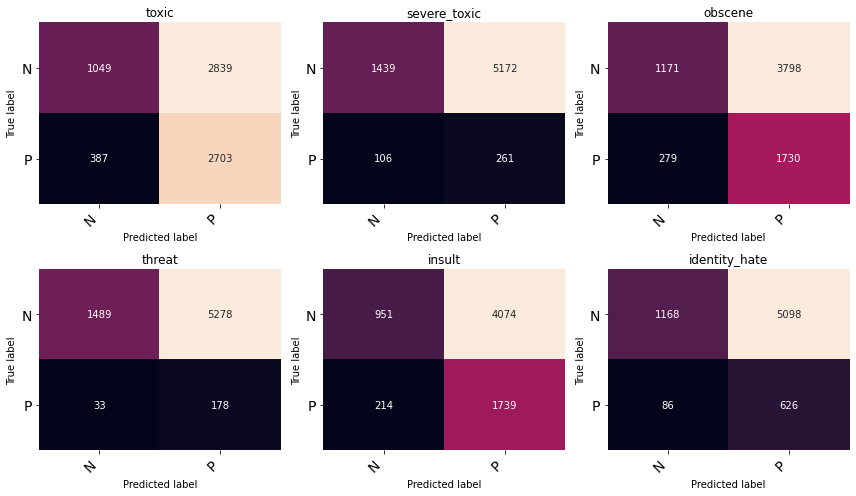

In [126]:
# Get confusion matrix
multi_cnb_false_confusion_matrix = get_confusion_matrix(y_pred_multi_cnb_false)

# Plot confusion matrix
plot_confusion_matrix(multi_cnb_false_confusion_matrix, labels)

This model is good $(\frac{FN}{TN} < 0.2)$ at classifying TN 'severe_toxic', 'threat' and 'identity_hate'. (3/6 labels)

It is decent $(\frac{FN}{TN} < 0.5)$ at classifying TN 'toxic', 'obscene' and 'insult'. (3/6 labels)

It is bad $(FP > TP)$ at classifying 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult' and 'identity_hate'. (6/6 labels)

Since it is bad at classifying for all labels, I will not take this classifier into consideration for future evaluations.

# NB Complement (MultiOutputClassifier)
## Without TFIDF
### Normalization = True

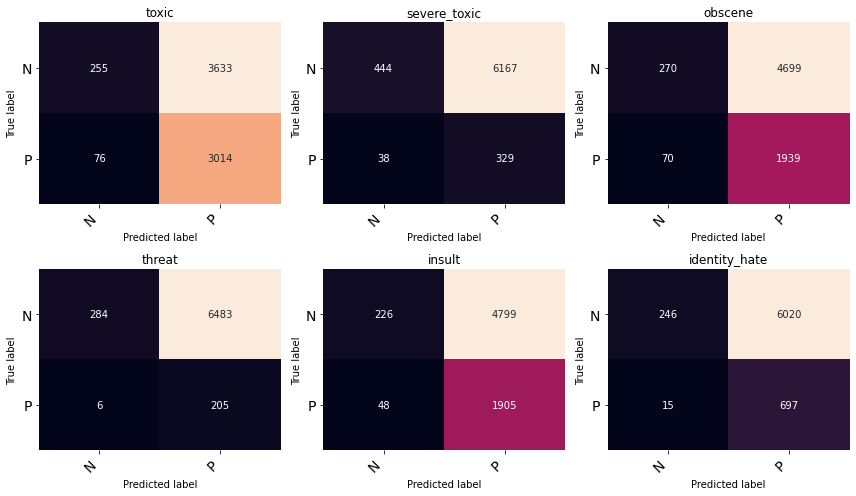

In [127]:
# Get confusion matrix
multi_cnb_true_confusion_matrix = get_confusion_matrix(y_pred_multi_cnb_true)

# Plot confusion matrix
plot_confusion_matrix(multi_cnb_true_confusion_matrix, labels)

This model is good $(\frac{FN}{TN} < 0.2)$ at classifying TN 'severe_toxic', 'threat' and 'identity_hate'. (3/6 labels)

It is decent $(\frac{FN}{TN} < 0.5)$ at classifying TN 'toxic', 'obscene' and 'insult'. (1/6 labels)

However, it has detected a low number of negative samples.

It is bad $(FP > TP)$ at classifying 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult' and 'identity_hate'. (6/6 labels)

Since it is bad at classifying for all labels, I will not take this classifier into consideration for future evaluations.

# NB Complement (MultiOutputClassifier)
## With TFIDF
### Normalization = False

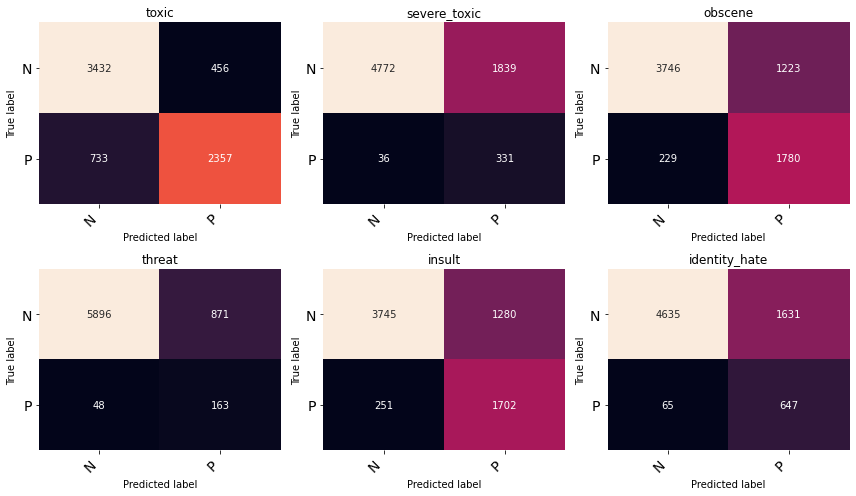

In [128]:
# Get confusion matrix
multi_cnb_tfidf_false_confusion_matrix = get_confusion_matrix(y_pred_multi_cnb_false_tfidf)

# Plot confusion matrix
plot_confusion_matrix(multi_cnb_tfidf_false_confusion_matrix, labels)

This model is good $(\frac{FN}{TN} < 0.2)$ at classifying TN 'severe_toxic', 'obscene', 'threat', 'insult' and 'identity_hate'. (5/6 labels)

It is decent $(\frac{FN}{TN} < 0.5)$ at classifying TN 'toxic'. (1/6 labels)

It is bad $(FP > TP$ or $\frac{FP}{TP} > 0.5)$ at classifying 'severe_toxic', 'obscene', 'threat', 'insult' and 'identity_hate'. (5/6 labels)

It is good $(\frac{FP}{TP} < 0.2)$ at classifying 'toxic'. (1/6 labels)

In [205]:
print(classification_report(y_true, y_pred_multi_cnb_false_tfidf, target_names=labels))

               precision    recall  f1-score   support

        toxic       0.84      0.76      0.80      3090
 severe_toxic       0.15      0.90      0.26       367
      obscene       0.59      0.89      0.71      2009
       threat       0.16      0.77      0.26       211
       insult       0.57      0.87      0.69      1953
identity_hate       0.28      0.91      0.43       712

    micro avg       0.49      0.84      0.62      8342
    macro avg       0.43      0.85      0.53      8342
 weighted avg       0.62      0.84      0.68      8342
  samples avg       0.23      0.36      0.27      8342

C:\Users\lamxw\anaconda3\envs\grp7_env\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lamxw\anaconda3\envs\grp7_env\lib\site-packages\sklear

This model performs well in Recall with every score > 0.7. It performs poorly in Precision with < 0.2 for 'severe_toxic' and 'threat'.It has a low micro-average Precision score. I will further compare with the next classifier to assess the classifier to use for further evaluations.

# NB Complement (MultiOutputClassifier)
## With TFIDF
### Normalization = True

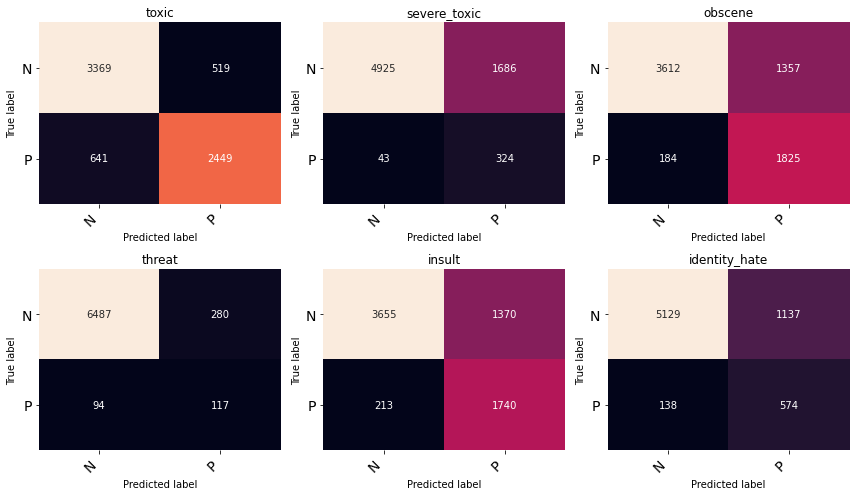

In [207]:
# Get confusion matrix
multi_cnb_tfidf_true_confusion_matrix = get_confusion_matrix(y_pred_multi_cnb_true_tfidf)

# Plot confusion matrix
plot_confusion_matrix(multi_cnb_tfidf_true_confusion_matrix, labels)

This model is good $(\frac{FN}{TN} < 0.2)$ at classifying TN 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult' and 'identity_hate'. (6/6 labels)

It is bad $(FP > TP)$ at classifying 'severe_toxic', 'obscene', 'threat', 'insult' and 'identity_hate'. (5/6 labels)

It is good $(\frac{FP}{TP} < 0.2)$ at classifying 'toxic'. (1/6 labels)

In [206]:
print(classification_report(y_true, y_pred_multi_cnb_true_tfidf, target_names=labels))

               precision    recall  f1-score   support

        toxic       0.83      0.79      0.81      3090
 severe_toxic       0.16      0.88      0.27       367
      obscene       0.57      0.91      0.70      2009
       threat       0.29      0.55      0.38       211
       insult       0.56      0.89      0.69      1953
identity_hate       0.34      0.81      0.47       712

    micro avg       0.53      0.84      0.65      8342
    macro avg       0.46      0.81      0.56      8342
 weighted avg       0.62      0.84      0.69      8342
  samples avg       0.25      0.37      0.28      8342

C:\Users\lamxw\anaconda3\envs\grp7_env\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lamxw\anaconda3\envs\grp7_env\lib\site-packages\sklear

This model performs well in Recall with every score > 0.7 with the exception of 'threat'. It performs poorly in Precision with < 0.2 for 'severe_toxic'. This classifer has a higher micro-average F1-score than the previous, thus for comparisons' sake I will use this classifier for future evaluations.

In [231]:
# Get sum of confusion matrices by classifier
cm_sum = sum(multi_cnb_tfidf_true_confusion_matrix)
cm_list_by_classifier.append(cm_sum.flatten())

# Save F1-score
micro_f1['multi_cnb_true_tfidf'] = f1_score(y_true, y_pred_multi_cnb_true_tfidf, average='micro')
# Get accuracy
acc_dict['multi_cnb_true_tfidf'] = get_accuracy(y_pred_multi_cnb_true_tfidf)
# Get micro-precision
micro_precision_score['multi_cnb_true_tfidf'] = precision_score(y_true, y_pred_multi_cnb_true_tfidf, average='micro')

# Conclusions from Confusion Matrix & Classification Report
Most classifiers, with the exception of Sequential Model, performed well for classifying TNs but performed worse for classifying FPs and TPs. 

Most classifiers perform better in Recall than Precision. 

Most classifiers consistently performed well classifying samples that contain 'toxic'.

The classifiers have vastly different results with and without TFIDF:

Sequential: 
* Sequential model's ability to classify positives decreased with TFIDF.
* Better performer: with TFIDF

LinearSVM: 
* LinearSVM without TFIDF had a high number of FPs and lower TNs compared to with TFIDF.
* Better performer: with TFIDF

SGDClassifier: 
* SGDClassifier without TFIDF had a higher number of FNs and lower TPs compared to with TFIDF.
* Better performer: with TFIDF

Multinomial Naive Bayes: 
* OneVsRest without TFIDF had a higher number of FPs and lower TNs compared to with TFIDF. However, with TFIDF, it performed poorer with classifying 'threats' and 'identity_hate'.
    * Better performer: with TFIDF
* MultiOutput without TFIDF performed similarly to OneVsRest. 
    * Better performer: with TFIDF

Complement Naive Bayes: <br>
OneVsRest without TFIDF performed similarly to MultinomialNB without TFIDF.
* Norm=True was extremely poor at detecting negatives.
* Better performer: Norm=False, but without TFIDF will not be considered due to overall poor performance.

OneVsRest with TFIDF was better at detecting TNs than without.
* Norm=False was better at correctly detecting TNs for 'toxic', 'obscene' and 'insult'.
* Norm=True was better at correctly detecting TNs for 'severe_toxic', 'threat' and 'identity_hate'.
* Norm=False was better at TPs for 'severe_toxic', 'threat' and 'identity_hate'.
* Norm=True was better at TPs for 'toxic', 'obscene' and 'insult'.
* Better performer: Norm=True with higher Precision and F1-scores

MultiOutput without TFIDF performed similarly to MultinomialNB without TFIDF.
* Norm=True was extremely poor at detecting negatives.
* Better performer: Norm=False, but without TFIDF will not be considered due to overall poor performance.

MultiOutput with TFIDF was better at detecting TNs than without.
* Norm=False performed similarly to OneVsRest.
* Norm=True performed similarly to OneVsRest.
* Better performer: Norm=True with higher Precision and F1-scores

# Bar Charts of Confusion Matrices by Classifier Variation
To get a better comparison of each classifier type at a glance, I will plot the sum of every confusion matrix by classifier (total for all 6 labels) to compare the classifier variations against each other.

In [262]:
# Plot a bar graph to show the number of TN, FP, FN, TP for each classifier
# Params:
#   List -      @cm_list_by_classifier:  List of confusion matrices sum by classifier
#   List -      @classifier_names:       List of names of classifiers
def plot_confusion_matrix_bar_classifier(cm_list_by_classifier, classifier_names):

    # Colour of bars
    colours = ['pink', 'royalblue', 'orange', 'mediumseagreen', 'chocolate', 'blueviolet', 'red']
    # Confusion matrix list
    cm_list = np.asarray(cm_list_by_classifier)

    # 4 categories (Confusion matrix squares)
    n = 4
    r = np.arange(n)
    width = 0.1

    plt.figure(figsize=(15, 5))

    for i in range(len(classifier_names)):

        plt.bar(
            r + width*i, 
            cm_list_by_classifier[i], # Bar data
            align='edge', 
            color=colours[i], 
            edgecolor='black', 
            label=classifier_names[i], 
            width=width
        )

    plt.xlabel("Confusion Matrix Labels")
    plt.ylabel("Number of comments")
    plt.title(f"Confusion Matrix Values of Classifiers")
    
    plt.xticks(r + width * len(classifier_names)/2, ['TN','FP','FN','TP'])
    plt.legend()
    
    plt.show()

In [ ]:
# Get names of all classifiers
classifier_names = list(micro_f1.keys())

# Create dataframe of accuracies
acc_df = pd.DataFrame.from_dict(acc_dict, orient='index', columns=['accuracy'])

# Create dataframe of micro-average F1-scores
micro_f1_df = pd.DataFrame.from_dict(micro_f1, orient='index', columns=['micro_avg_f1_score'])

# Create dataframe of micro-average precision scores
micro_precision_df = pd.DataFrame.from_dict(micro_precision_score, orient='index', columns=['micro_avg_precision_score'])

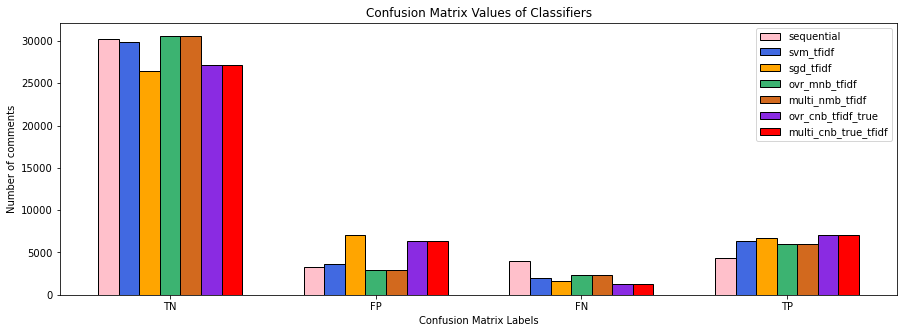

In [263]:
plot_confusion_matrix_bar_classifier(cm_list_by_classifier, classifier_names)

1. OneVsRest and MultiOutput Multinomial NB have the highest TN and lowest FP values.
2. OneVsRest and MultiOutput Complement NB have the highest TP values but one of the lowest TN values, with high FP values. Thus they do not perform as well as other classifiers.
3. Sequential has one of the highest TN values but the lowest TP value, thus it does not perform as well as the other classifiers.
4. SVM performs decently well, with one of the highest TN and TP values and one of the lowest FN and FP values.
5. SGD performs poorly, with the lowest TN and highest FP values. 

# Micro-average F1-score, Micro-average Precision score and Accuracy
For further comparison, I will be comparing these 3 metrics to determine the best performing classifier.

In [288]:
print(micro_f1_df.sort_values(by=['micro_avg_f1_score'], ascending=False))

                      micro_avg_f1_score
ovr_mnb_tfidf                   0.697661
multi_nmb_tfidf                 0.697661
svm_tfidf                       0.692362
ovr_cnb_tfidf_true              0.647238
multi_cnb_true_tfidf            0.647238
sgd_tfidf                       0.603910
sequential                      0.540246


In [287]:
print(micro_precision_df.sort_values(by=['micro_avg_precision_score'], ascending=False))

                      micro_avg_precision_score
ovr_mnb_tfidf                          0.673131
multi_nmb_tfidf                        0.673131
svm_tfidf                              0.635689
sequential                             0.566229
ovr_cnb_tfidf_true                     0.525415
multi_cnb_true_tfidf                   0.525415
sgd_tfidf                              0.484392


In [282]:
print(acc_df.sort_values(by=['accuracy'], ascending=False))

                      accuracy
ovr_mnb_tfidf         0.874964
multi_nmb_tfidf       0.874964
svm_tfidf             0.865410
sequential            0.824830
ovr_cnb_tfidf_true    0.816996
multi_cnb_true_tfidf  0.816996
sgd_tfidf             0.790460


# Conclusion - Best Performing Classifier
## Multinomial Naive Bayes with TFIDF (OneVsRest and MultiOutputClassifier)
OneVsRest and MultiOutput **Multinomial Naive Bayes** with TFIDF is the best performing classifier for our dataset, despite our dataset being imbalanced. I had expected Complement Naive Bayes to perform better for that reason.

According to sklearn's guide to choosing the right estimator (https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html), I had expected LinearSVC to perform the best. Its F1-score was close to Multinomial NB but it performed worse in Precision.

After viewing the evaluation results, it has become apparent that Multinomial NB wrapped in OneVsRest and MultiOutputClassifier perform exactly the same. From research, I observed that every tutorial and guide for multilabel problems wrapped LinearSVC in MultiOutputClassifier instead of OneVsRest. I attempted to wrap LinearSVC in OneVsRest but I was unsuccessful in applying my labels to the OneVsRest wrapper.

Likewise, I observed that every tutorial and guide for multilabel problems wrapped Multinomial Naive Bayes in OneVsRest instead of MultiOutputClassifier. This time, I was successful in applying my labels to both wrappers so I wanted to observe if there was a difference in using OneVsRest compared to MultiOutputClassifier and expected MultiOutputClassifier to perform worse.

# Issues Faced
SGDClassifier contained many hyperparameters that needed trial and error to find the best hyperparameters for the classifier, which meant it was necessary to use GridSearchCV to determine the best hyperparameters. Unfortunately I was bottlenecked by my personal laptop and lack of time. I had only attempted one run of GridSearchCV overnight and it took between 4-8 hours.

This experiment was the most time consuming due to the need to adjust hyperparameters. I used the default hyperparameters at the starting point for most classifiers and retrained the classifiers to experiment with the hyperparameters. I was not able to use GridSearchCV so I was restricted to trying a small range of hyperparameter values.